# 1D Wave Equation Modeling Using PINNs (Non-Constant Velocity Medium)
The goal of this notebook is to use a Physics-Informed Neural Net (PINN) to predict the seismic wavefield generated by some (given) initial conditions in a 1D acoustic isotropic medium with **non-constant velocity**. 

## Outline
- We create a neural net which takes into input the position $x$ and the time $t$. The output is the acoustic pressure $p(x,t)$ at this location/time
- We start with some initial conditions and we enforce a boundary condition on the 1D modeling domain: 
    1. Two initial conditions on the pressure field itself and on its time derivative
    $$ p(x,t=0) = sin(x) $$ and $$\frac{\partial p(x,t)}{\partial t}|_{t=0} = sin(x),$$ for all $x \in [0, L]$, where $L$ is the length of the domain.   
    2. One boundary condition 
    $$p(x,t) = 0,$$ for all $t$ and $x\in \{0,L\}$.
    3. One constraint enforcing the pressure field to satisfy the wave-equation inside the 1D modeling domain:
        $$\frac{1}{v(x)^2}\frac{\partial^2 p(x,t)}{\partial t^2} - \frac{\partial^2 p(x,t)}{\partial x^2} = 0,$$ for all $x \in [0,L]$ and $t \in [0, 2L].$ 
- For the training stage of the PINN, we add these four constraints
- In this notebook, we compare the **PINN solution** with the **analytical solution** and the numercial solution obtained using a **finite-difference (FD)** scheme  

## Finite-difference solution

In [1]:
# Import modules
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
################## Load PINN solution ##################
L = float(np.pi)
x = np.arange(0, L, 0.01)
t = np.arange(0, 2*L, 0.01)
nx = x.shape[0]
nt = t.shape[0]
X, T = np.meshgrid(x, t)


In [3]:
################## FD solution ##################
# Sampling
dx = 0.01
dt = 0.001

# Boundaries
L = float(np.pi)
x0 = 0
x1 = np.pi
t0 = 0
t1 = 2*np.pi
fmax = 1.0/(2*np.pi)
s = dt*dt/(dx*dx)

# Generate 1D mesh
x_fd = np.arange(x0, x1, dx)
t_fd = np.arange(t0, t1, dt)
nx_fd = x_fd.shape[0]
nt_fd = t_fd.shape[0]

# Velocity
v_fd = np.zeros((nx_fd))

#########################
# Different ways to parametrize the velocity contrast
# v_fd = 1.0 + 0.2*np.sin(x_fd)*np.sin(x_fd)
# v_fd[0:nx_fd//2] = 1.0
# v_fd[nx_fd//2:] = 2.0
#########################

# Note: k increases -> sharpness of velocity contrast increases
k = 10
v_fd = 1.0 + 1.0 / (1.0 + np.exp(-2*k*(x_fd-1.5)))

# FD stability/dispersion
courant = v_fd.max()*dt/dx
disp = v_fd.min()/(dt*fmax)
print("Courant:" , courant)
print("Dispersion:" , disp)

## Finite-difference solution
u_fd = np.zeros((nt_fd, nx_fd))
u_fd[0,:] = np.sin(x_fd)
u_fd[1,:] = np.sin(x_fd)*(dt+1)
for it in range(2,nt_fd,1):
    for ix in range(2,nx_fd-1,1):
        u_fd[it,ix] = 2*(1-s*v_fd[ix]*v_fd[ix])*u_fd[it-1,ix] - u_fd[it-2,ix] + s*v_fd[ix]*v_fd[ix]*(u_fd[it-1,ix+1]+u_fd[it-1,ix-1]) 


Courant: 0.19999999999999943
Dispersion: 6283.185307180173


## PINN solution
Modify the file ``problem.py`` and train the PINN. Then, load the solution and compare the predicted pressure wavefield with the finite-difference solution

In [4]:
################## Load PINN solution ##################
import training.stage1.infer as infer_stage1

# Display information on inferencer
infer_stage1.info

# Predicted solution
u1 = infer_stage1.infer(x=X, t=T)['u']
u1 = u1.reshape(X.shape)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


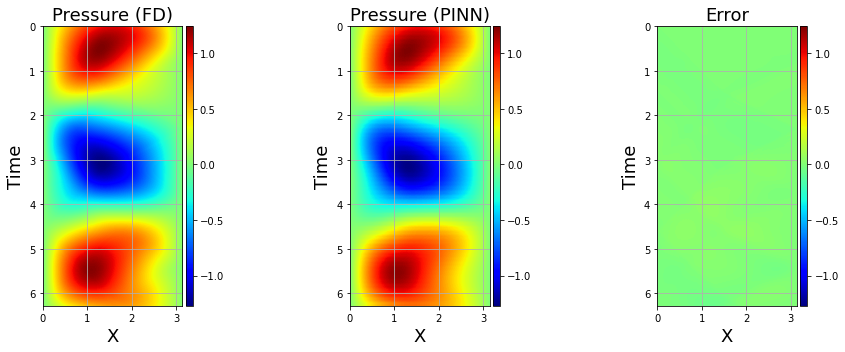

In [5]:
################## Plotting pressure field ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# PINN solution
img0 = axs[0].imshow(u_fd, cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Time', fontsize=18)
axs[0].set_title('Pressure (FD)', fontsize=18)
axs[0].grid()
plt.tight_layout()

# FD solution
img4 = axs[1].imshow(u1[0::10,:], cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img4, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Time', fontsize=18)
axs[1].set_title('Pressure (PINN)', fontsize=18)
axs[1].grid()
plt.tight_layout()

# Error
img4 = axs[2].imshow(u_fd[0::10,:]-u1, cmap='jet', vmin=u_fd.min(), vmax=u_fd.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img4, cax=cax)
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Time', fontsize=18)
axs[2].set_title('Error', fontsize=18)
axs[2].grid()
plt.tight_layout()

# Save figure
plt.savefig("we-fwd-1d-ncv-pressure.png")

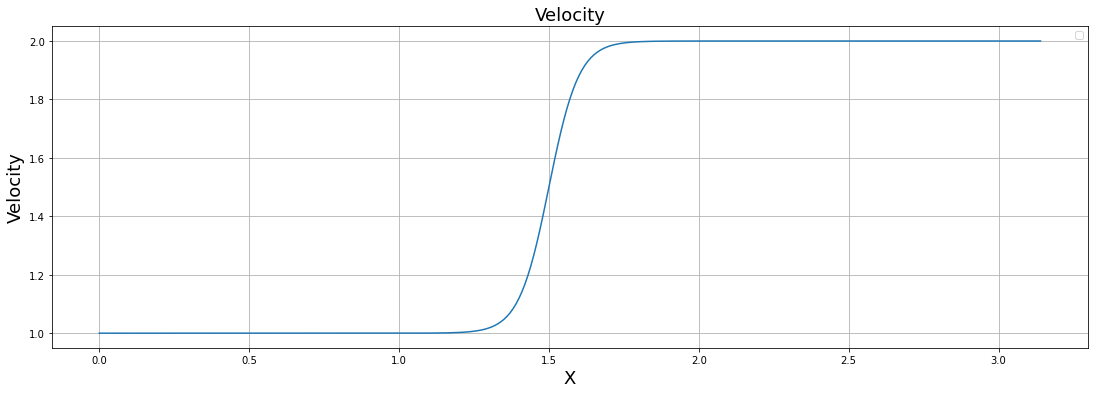

In [6]:
################## Velocity profile ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# FD solution
img0 = axs.plot(x_fd, v_fd)
plt.tight_layout()
axs.grid()
axs.set_xlabel('X', fontsize=18)
axs.set_ylabel('Velocity', fontsize=18)
axs.set_title('Velocity', fontsize=18)
axs.legend()

# Save figure
plt.savefig("we-fwd-1d-ncv-velocity-profile.png")